# 장르 분석 : CNN_self + LSTM lstm autoencoder
- 프로젝트에 사용된 파일

In [23]:
# 모듈 로딩
import pandas as pd
import numpy as np

from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt

# 데이터 불러오기

In [24]:
from torchvision.datasets import ImageFolder 

train_root = "./spectrograms" # 해당 경로 내에 있는 파일명이 곧 label이 되는 것

preprocessing = transforms.Compose([
    transforms.Resize((100, 100), interpolation=transforms.InterpolationMode.BILINEAR), 
    # transforms.Grayscale(),
    transforms.ToTensor(),  # 3. 값의 크기를 0~1로
])

imgDS = ImageFolder(root=train_root, transform=preprocessing)

In [25]:
imgDS.samples

[('./spectrograms\\ballade\\ballade0.png', 0),
 ('./spectrograms\\ballade\\ballade1.png', 0),
 ('./spectrograms\\ballade\\ballade10.png', 0),
 ('./spectrograms\\ballade\\ballade11.png', 0),
 ('./spectrograms\\ballade\\ballade12.png', 0),
 ('./spectrograms\\ballade\\ballade13.png', 0),
 ('./spectrograms\\ballade\\ballade14.png', 0),
 ('./spectrograms\\ballade\\ballade15.png', 0),
 ('./spectrograms\\ballade\\ballade16.png', 0),
 ('./spectrograms\\ballade\\ballade17.png', 0),
 ('./spectrograms\\ballade\\ballade18.png', 0),
 ('./spectrograms\\ballade\\ballade19.png', 0),
 ('./spectrograms\\ballade\\ballade2.png', 0),
 ('./spectrograms\\ballade\\ballade20.png', 0),
 ('./spectrograms\\ballade\\ballade21.png', 0),
 ('./spectrograms\\ballade\\ballade22.png', 0),
 ('./spectrograms\\ballade\\ballade23.png', 0),
 ('./spectrograms\\ballade\\ballade24.png', 0),
 ('./spectrograms\\ballade\\ballade25.png', 0),
 ('./spectrograms\\ballade\\ballade26.png', 0),
 ('./spectrograms\\ballade\\ballade27.png',

## 데이터 셋이 잘 읽혔는지 확인

In [26]:
imgDS.classes, imgDS.class_to_idx

(['ballade', 'dance', 'trot'], {'ballade': 0, 'dance': 1, 'trot': 2})

In [27]:
from sklearn.model_selection import train_test_split

# 이미지 데이터와 레이블을 가져옴
images = [img for img, _ in imgDS]
labels = [label for _, label in imgDS]

# Stratified sampling을 사용하여 train, validation, test 세트로 분할
train_images, valtest_images, train_labels, valtest_labels = train_test_split(images, labels, test_size=0.2, stratify=labels)
val_images, test_images, val_labels, test_labels = train_test_split(valtest_images, valtest_labels, test_size=0.5, stratify=valtest_labels)

In [28]:
# split 결과 비율 확인 
print(np.unique(np.array(train_labels),  return_counts=True))
print(np.unique(np.array(val_labels),  return_counts=True))
print(np.unique(np.array(test_labels),  return_counts=True))

(array([0, 1, 2]), array([80, 80, 80], dtype=int64))
(array([0, 1, 2]), array([10, 10, 10], dtype=int64))
(array([0, 1, 2]), array([10, 10, 10], dtype=int64))


In [29]:
class CustomDataset(Dataset): 
  def __init__(self, data, label):
      self.data = data
      self.label = torch.LongTensor(label)

  def __len__(self):
      return len(self.data)
  
  def __getitem__(self, idx): 
      x = self.data[idx]
      y = self.label[idx]
      return x, y

In [30]:
# 데이터셋 생성
train_dataset = CustomDataset(train_images, train_labels)
val_dataset = CustomDataset(val_images, val_labels)
test_dataset = CustomDataset(test_images, test_labels)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=320, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=40)

In [31]:
for batch_idx, (data, labels) in enumerate(train_loader):
    print('Batch', batch_idx)
    print('Data shape:', data.shape)
    print('Labels:', torch.bincount(labels))
    print()

Batch 0
Data shape: torch.Size([240, 3, 100, 100])
Labels: tensor([80, 80, 80])



# CNN 모델 생성

In [32]:
### ===> 딥러닝 모델을 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.2  Device: cpu


In [33]:
# 사전 학습된 모델 로딩
# import torchvision.models as models # 다양한모델패키지
# model = models.vgg16(pretrained=True)

# # 사전 훈련된 모델의 파라미터 학습 유무 설정 함수
# def set_parameter_requires_grad(model, feature_extract = True):
#     if feature_extract:
#         for param in model.parameters():
#             param.requires_grad = False # 학습하는 것을 방지

# set_parameter_requires_grad(model) # 함수 호출

In [34]:
# 분류기 부분을 이진 분류기로 수정하는 클래스 정의
class MultiClassCNN(nn.Module):
    def __init__(self):
        super(MultiClassCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 100 * 100, 128)  # 64개의 채널, 100x100 이미지 크기
        self.fc2 = nn.Linear(128, 3)  # 다중 클래스 분류에 필요한 출력 뉴런 3개
        
    def forward(self, x):
        x = F.relu(self.conv1(x))  # 100x100x16
        x = F.relu(self.conv2(x))  # 100x100x32
        x = F.relu(self.conv3(x))  # 100x100x64
        x = x.view(-1, 64 * 100 * 100)  # 전체 데이터를 1차원으로 펼침
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [35]:

hidden_size = 128
num_layers = 5
num_classes = 4
num_epochs = 10
learning_rate = 0.001

cnn_model = MultiClassCNN()

# optimizer = torch.optim.Adam(list(cnn_model.parameters()) + list(lstm_autoencoder.parameters()) + list(classification_model.parameters()), lr=0.001, weight_decay=1e-4)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr = 0.001)

criterion = nn.CrossEntropyLoss() # binary_cross_entropy

In [36]:
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2, 3, 4, 8, 13, 18, 25, 30], gamma=0.5)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2, 6, 8, 13, 18, 25, 30], gamma=0.5)

In [45]:
cnn_model

MultiClassCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=640000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [37]:
# CNN 모델 학습 진행 함수
def train(epoch, model, dataloader, criterion, optimizer):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0
    correct = 0.0
    
    for inputs, labels in dataloader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
     
        # Loss 계산
        loss = criterion(outputs, labels)

        # Backward pass 및 가중치 업데이트
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        prediction = outputs.max(1, keepdim = True)[1]
        correct += prediction.eq(labels.view_as(prediction)).sum().item()
    
    # epoch당 평균 손실
    total_loss = running_loss / len(dataloader.dataset)
    
    total_loss /= len(train_loader.dataset) # 평균 손실 
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return total_loss, train_accuracy

In [38]:
### 검증 validation 진행 함수 
def evaluate(model, dataloader, criterion):
    model.eval()  # 모델을 평가 모드로 설정
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            # Forward pass
            outputs = model(inputs)
            
            # Loss 계산
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            
            # 정확도 계산
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
    
    # 평가 결과
    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = correct_preds / total_preds
    
    return epoch_loss, accuracy

# 학습 진행

In [39]:
# CNN 학습
EPOCHS = 20

# 최고 성능 모델의 가중치 저장
best_model_weights = None
best_test_loss = np.inf
patience = 10  # 조기 종료를 위한 참을성 값 설정
counter = 0  # 성능이 향상되지 않는 epoch 카운터

train_loss_acc = [[],[]]
val_loss_acc = [[],[]]

for epoch in range(1, EPOCHS + 1):
    # train(epoch, model, dataloader, criterion, optimizer):
    train_loss, train_acc = train(epoch, cnn_model, train_loader, criterion, optimizer)
    train_loss_acc[0].append(train_loss)
    train_loss_acc[1].append(train_acc)
    
    
    test_loss, test_accuracy = evaluate(cnn_model, test_loader, criterion)
    print(f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} %")
    val_loss_acc[0].append(test_loss)
    val_loss_acc[1].append(test_accuracy)
    
    # 조기 종료 검사
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model_weights = cnn_model.state_dict()  # 최고 성능 모델의 가중치 저장
        counter = 0  # 카운터 초기화
    else:
        counter += 1  # 성능이 향상되지 않음
        
        if counter >= patience:
            print("조기 종료: 검증 손실이 이전에 관측된 최적의 손실보다 높아짐")
            break
    # scheduler.step() # 스케줄러 
            
# 최고 성능 모델의 가중치로 모델을 업데이트
if best_model_weights is not None:
    cnn_model.load_state_dict(best_model_weights)


[EPOCH: 1], 	Test Loss: 13.4482, 	Test Accuracy: 0.33 %

[EPOCH: 2], 	Test Loss: 11.8154, 	Test Accuracy: 0.33 %

[EPOCH: 3], 	Test Loss: 5.9067, 	Test Accuracy: 0.33 %

[EPOCH: 4], 	Test Loss: 2.0457, 	Test Accuracy: 0.33 %

[EPOCH: 5], 	Test Loss: 1.7686, 	Test Accuracy: 0.33 %

[EPOCH: 6], 	Test Loss: 1.3038, 	Test Accuracy: 0.33 %

[EPOCH: 7], 	Test Loss: 1.1965, 	Test Accuracy: 0.33 %

[EPOCH: 8], 	Test Loss: 1.1177, 	Test Accuracy: 0.33 %

[EPOCH: 9], 	Test Loss: 1.0855, 	Test Accuracy: 0.33 %

[EPOCH: 10], 	Test Loss: 1.0639, 	Test Accuracy: 0.33 %

[EPOCH: 11], 	Test Loss: 1.0478, 	Test Accuracy: 0.53 %

[EPOCH: 12], 	Test Loss: 1.0396, 	Test Accuracy: 0.47 %

[EPOCH: 13], 	Test Loss: 1.0293, 	Test Accuracy: 0.40 %

[EPOCH: 14], 	Test Loss: 0.9775, 	Test Accuracy: 0.60 %

[EPOCH: 15], 	Test Loss: 0.8847, 	Test Accuracy: 0.80 %

[EPOCH: 16], 	Test Loss: 0.7743, 	Test Accuracy: 0.77 %

[EPOCH: 17], 	Test Loss: 0.7161, 	Test Accuracy: 0.67 %

[EPOCH: 18], 	Test Loss: 0.5536, 	Tes

In [40]:
for i in range(len(val_loss_acc[1])):
	val_loss_acc[1][i] = val_loss_acc[1][i] * 100

In [41]:
for i in range(len(train_loss_acc[0])):
	train_loss_acc[0][i] = train_loss_acc[0][i] * 100

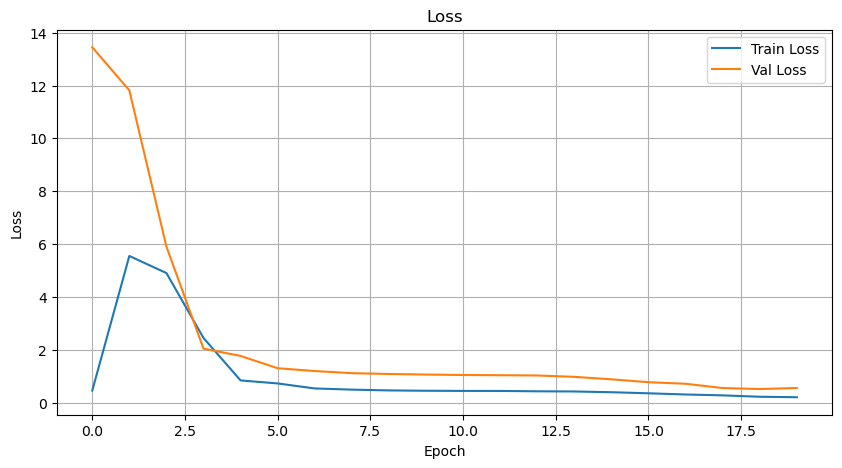

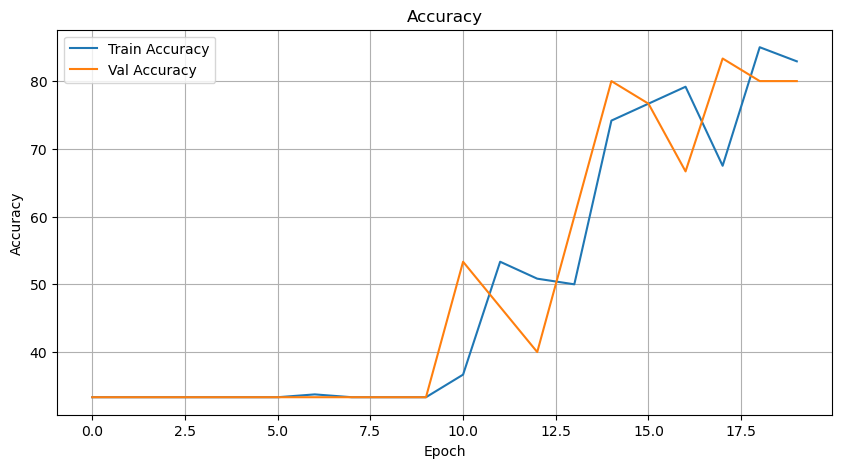

In [42]:
from matplotlib import pyplot as plt
# Loss 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_loss_acc[0], label='Train Loss') # 
plt.plot(val_loss_acc[0], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid()
plt.legend()
plt.show()

# Accuracy 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_loss_acc[1], label='Train Accuracy')
plt.plot(val_loss_acc[1], label='Val Accuracy') # 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid()
plt.show()

# test data predict

In [43]:
def predict(model, val_loader):
    model.eval()
    correct = 0

    with torch.no_grad():
        for image, label in val_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            label = label.float()
            output = model(image)
            # print(output.max(1, keepdim = True))
            # prediction = output.round()  # 이진 분류에서는 반올림하여 0 또는 1로 변환
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_accuracy = 100. * correct / len(val_loader.dataset)
    return test_accuracy

predict(cnn_model, test_loader)

80.0

In [44]:
# torch.save(classification_model.state_dict(), 'classification_model.pth')